## Problem Statement

- The goal of this competition is to design a predictive model that accurately classifies movies into their respective genres based on their titles and synopses.

- The challenge lies not just in achieving high accuracy, but also in ensuring that the model is efficient and interpretable.

- The 10 genres include action, adventure, crime, family, fantasy, horror, mystery, romance, scifi, and thriller.


Dataset
https://www.kaggle.com/datasets/guru001/movie-genre-prediction

- We can try building multiclass classification model or multilabel prediction model from this dataset.



## Importing all necessary libraries

In [ ]:
import os
import re
import spacy
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Downloading the dataset from Kaggle

In [ ]:
!gdown https://drive.google.com/uc?id=1fmkKPI6FkAofx-V7L3_F-YZmblp9Rv6y

Downloading...
From: https://drive.google.com/uc?id=1fmkKPI6FkAofx-V7L3_F-YZmblp9Rv6y
To: /content/train.csv
100% 9.96M/9.96M [00:00<00:00, 93.0MB/s]


## Loading the data into a pandas dataframe

In [ ]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(54000, 4)


,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


In [ ]:
df['id'].value_counts()

44978    1
5945     1
87606    1
13196    1
29043    1
        ..
59051    1
74162    1
78146    1
85223    1
33970    1
Name: id, Length: 54000, dtype: int64

- Since every rows in id is unique, it does not carry any important information for predicting genres.
- That's the reason why we are dropping id column in our analysis.

In [ ]:
df.drop('id', axis=1, inplace = True)

## Checking the overall statistics of categorical features

In [ ]:
df.describe(include="O")

,movie_name,synopsis,genre
count,54000,54000,54000
unique,43687,46046,10
top,The Little Mermaid,Plot kept under wraps.,fantasy
freq,13,107,5400


- The movie name "The Little Mermaid" has been repeated 13 times. Is there duplications in the data?
- Do we have the same name for the movie with different plots, synopsis and stories?

## Data Cleaning

- Checking duplicates
- Checking missing values

## Checking Duplicates

In [ ]:
df[df.duplicated()]

,movie_name,synopsis,genre


- There are no duplicate items in the dataset meaning that even though the name of movie can be same but the synopsis for the movie is different.

## Checking for null values

In [ ]:
df.isnull().sum()

movie_name    0
synopsis      0
genre         0
dtype: int64

## EDA

In [ ]:
def create_univariate_bargraph(df, xaxis_col, yaxis_col,
                               title = "", color=None):
  plt.figure(figsize=(8, 6))
  sns.barplot(data=df, x = xaxis_col, y=yaxis_col, palette=color, orient="h")
  plt.title(title)
  plt.show()

In [ ]:
def univariate_freq_count(df, cat_col):
  frequency_df = df[cat_col].value_counts().to_frame().reset_index()
  frequency_df.columns = [cat_col, 'frequency']
  return frequency_df

## Visualizing Target Features

In [ ]:
df['genre'].value_counts()

fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: genre, dtype: int64

In [ ]:
genre_df = univariate_freq_count(df = df, cat_col = "genre")
genre_df

,genre,frequency
0,fantasy,5400
1,horror,5400
2,family,5400
3,scifi,5400
4,action,5400
5,crime,5400
6,adventure,5400
7,mystery,5400
8,romance,5400
9,thriller,5400


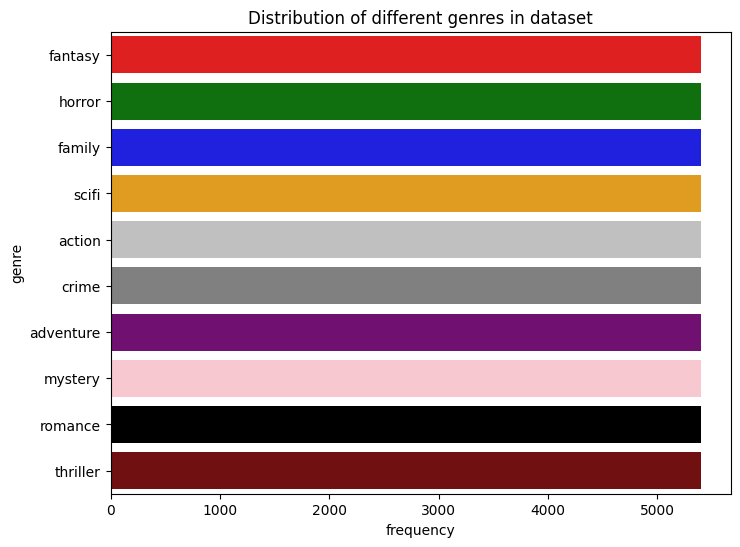

In [ ]:
create_univariate_bargraph(df = genre_df, xaxis_col = "frequency",
                           yaxis_col = "genre",
                           title = "Distribution of different genres in dataset",
                           color=["red", "green", "blue", "orange", "silver",
                                  "gray", "purple", "pink", "black", "maroon"])

- The dataset is fairly balanced among all of the 10 different classes.
- 'Fantasy', 'Horror', 'Family', 'Scifi', 'Action', 'Crime', 'Adventure', 'Mystery', 'Romance' & 'Thriller' are the 10 different genres classified to a movie.

## Data Preprocessing: Text Cleaning

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def remove_stopwords_and_lemmatize(text):
    # Parse the input text with spaCy
    doc = nlp(text)
    # Lemmatize each token and remove stopwords
    cleaned_text = " ".join(token.lemma_ for token in doc if not token.is_stop)
    return cleaned_text


In [ ]:
def clean_text(text):
    doc = nlp(text)
    cleaned_text = ' '.join(token.text.lower() for token in doc if not token.is_punct)
    cleaned_text = re.sub(r'\s+', ' ', re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)).strip()
    return cleaned_text


In [ ]:
df['synopsis'] = df['synopsis'].apply(remove_stopwords_and_lemmatize)

In [ ]:
df['synopsis'] = df['synopsis'].apply(clean_text)

In [ ]:
df['final_synopsis'] = df['synopsis']

## Filtering features; keeping only the predictor variables and the target feature

In [ ]:
final_df = df[['final_synopsis', 'genre']]

# Check for duplicates after text cleaning

In [ ]:
final_df[final_df.duplicated()]

,final_synopsis,genre
1897,plot undisclosed,mystery
1918,plot keep wrap,thriller
1986,plot keep wrap,scifi
2697,plot wrap,thriller
2904,plot wrap,scifi
...,...,...
53436,plot keep wrap,scifi
53472,plot wrap,family
53632,plot detail keep wrap,thriller
53683,plot unknown time,mystery


In [ ]:
final_df = final_df[~final_df.duplicated()]
print(final_df.shape)

(53695, 2)


In [ ]:
final_df.to_csv("clean_train.csv", index=False)

## EDA

In [ ]:
def find_top_words(df, label):
  label_df = df[df['genre']==label]
  word_count_dict = {}
  for item in label_df.values:
    words = item[0].split(" ")
    for word in words:
      if word not in word_count_dict:
        word_count_dict[word] = 1
      else:
        word_count_dict[word] += 1
  word_count_df = pd.DataFrame({"words": word_count_dict.keys(),
                               "frequency": word_count_dict.values()})
  word_count_df.sort_values("frequency", ascending=False, inplace=True)
  return word_count_df

In [ ]:
final_df['genre'].value_counts()

crime        5388
family       5387
mystery      5384
romance      5383
fantasy      5370
adventure    5370
horror       5364
action       5363
thriller     5356
scifi        5330
Name: genre, dtype: int64

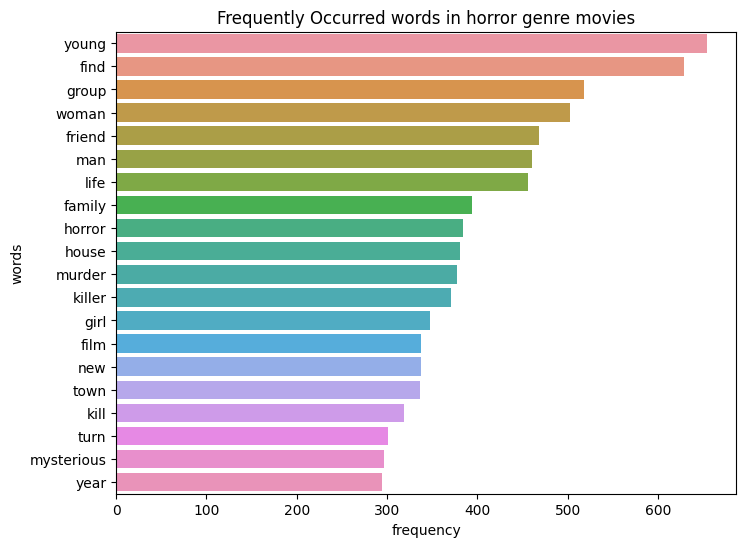

In [ ]:
horror_count_df = find_top_words(final_df, 'horror')
create_univariate_bargraph(df = horror_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in horror genre movies"
                           )

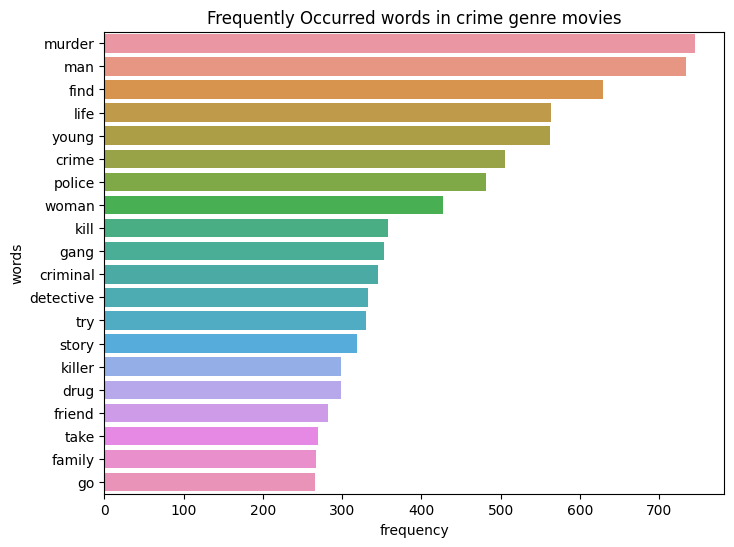

In [ ]:
crime_count_df = find_top_words(final_df, 'crime')
create_univariate_bargraph(df = crime_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in crime genre movies"
                           )

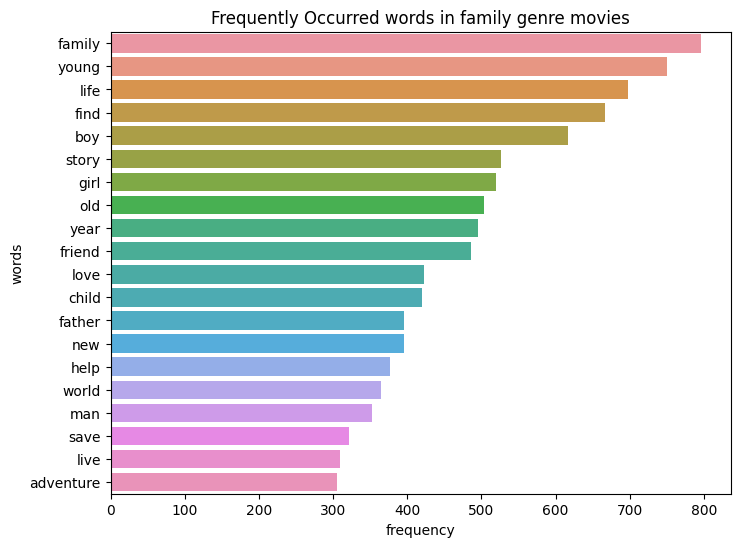

In [ ]:
family_count_df = find_top_words(final_df, 'family')
create_univariate_bargraph(df = family_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in family genre movies"
                           )

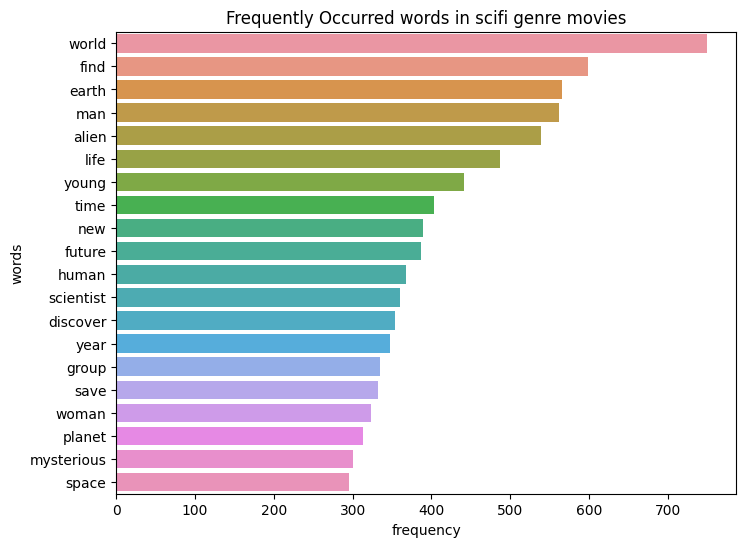

In [ ]:
scifi_count_df = find_top_words(final_df, 'scifi')
create_univariate_bargraph(df = scifi_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in scifi genre movies"
                           )

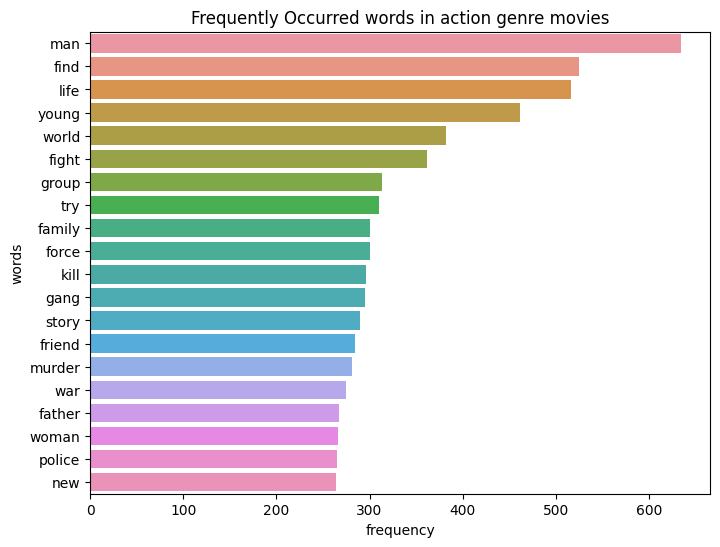

In [ ]:
action_count_df = find_top_words(final_df, 'action')
create_univariate_bargraph(df = action_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in action genre movies"
                           )

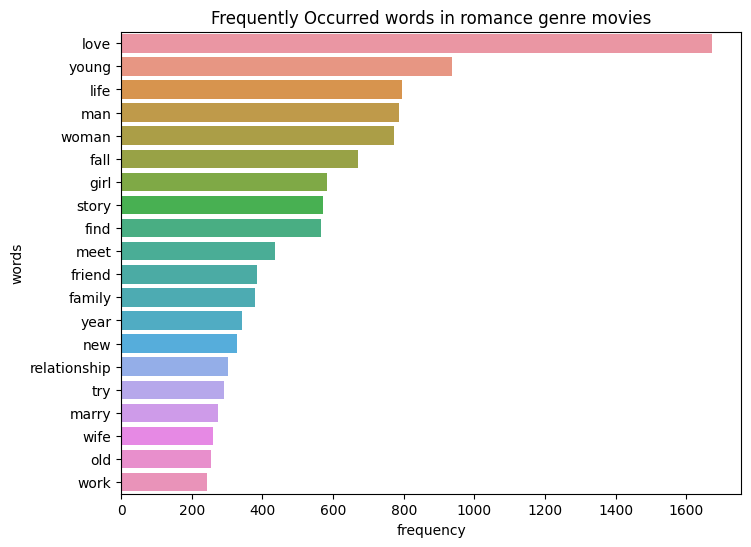

In [ ]:
romance_count_df = find_top_words(final_df, 'romance')
create_univariate_bargraph(df = romance_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in romance genre movies"
                           )

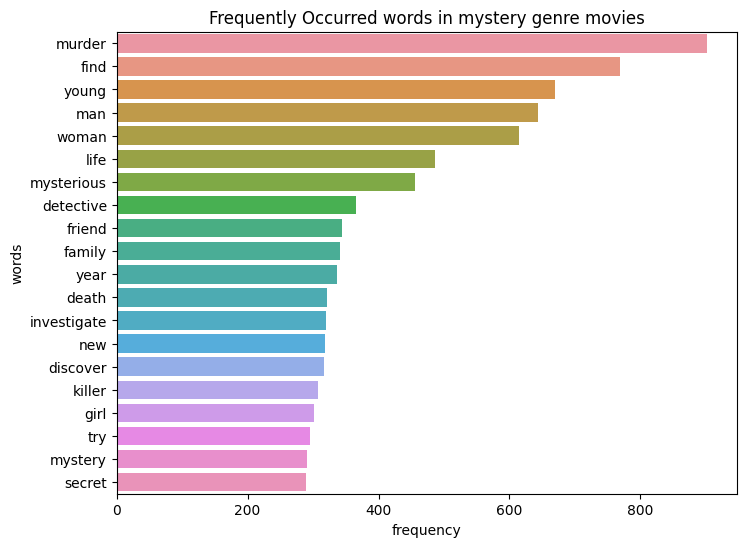

In [ ]:
mystery_count_df = find_top_words(final_df, 'mystery')
create_univariate_bargraph(df = mystery_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in mystery genre movies"
                           )

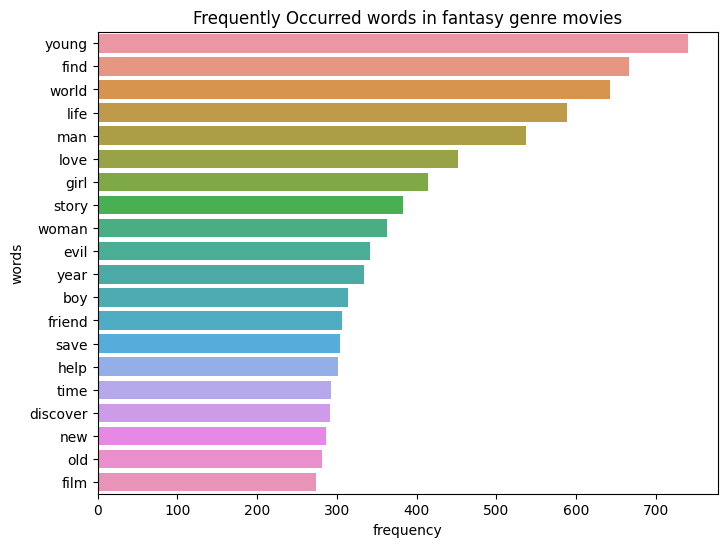

In [ ]:
fantasy_count_df = find_top_words(final_df, 'fantasy')
create_univariate_bargraph(df = fantasy_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in fantasy genre movies"
                           )

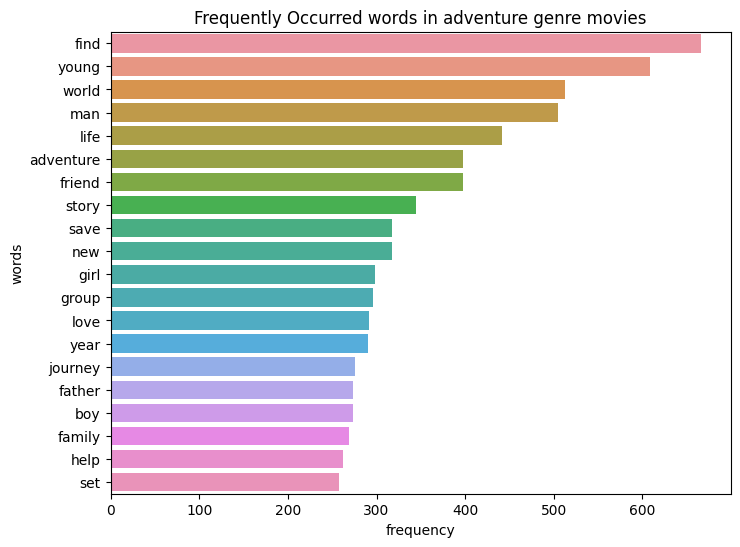

In [ ]:
adventure_count_df = find_top_words(final_df, 'adventure')
create_univariate_bargraph(df = adventure_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in adventure genre movies"
                           )

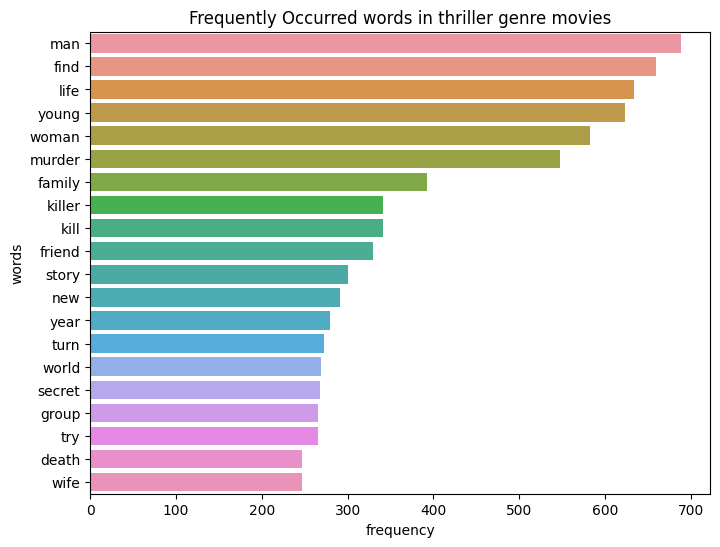

In [ ]:
thriller_count_df = find_top_words(final_df, 'thriller')
create_univariate_bargraph(df = thriller_count_df.head(20),
                           xaxis_col = "frequency", yaxis_col = "words",
                               title = "Frequently Occurred words in thriller genre movies"
                           )


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## Multiclass Classification Problem

In [ ]:
synopsis_count_df = univariate_freq_count(df = final_df, cat_col = "final_synopsis")
filter_synopsis = list(synopsis_count_df.loc[synopsis_count_df['frequency']==1,
                                             'final_synopsis'])

In [ ]:
multiclass_df = final_df[final_df['final_synopsis'].isin(filter_synopsis)]
multiclass_df.shape

(39313, 2)

In [ ]:
multiclass_df.head()

,final_synopsis,genre
0,young scriptwriter start bring valuable object...,fantasy
1,director friend rent haunt house capture paran...,horror
2,educational video family family therapist desc...,family
4,buy day men widely apart life night shadows un...,action
6,video voyeur stalk woman city digital camera c...,horror


## Encode our labels

In [ ]:
le = LabelEncoder()
multiclass_df['genre_labels'] = le.fit_transform(multiclass_df['genre'])

In [ ]:
multiclass_df

,final_synopsis,genre,genre_labels
0,young scriptwriter start bring valuable object...,fantasy,4
1,director friend rent haunt house capture paran...,horror,5
2,educational video family family therapist desc...,family,3
4,buy day men widely apart life night shadows un...,action,0
6,video voyeur stalk woman city digital camera c...,horror,5
...,...,...,...
53994,ragtag gang international talking dog mascot s...,family,3
53995,loser pest control buddy find battle alien sle...,scifi,8
53996,seductive woman gets involve relationship peop...,thriller,9
53997,duyen wedding dress staff decide continue preg...,romance,7


In [ ]:
le.classes_

array(['action', 'adventure', 'crime', 'family', 'fantasy', 'horror',
       'mystery', 'romance', 'scifi', 'thriller'], dtype=object)

## Data Preparation

In [ ]:
data = multiclass_df["final_synopsis"]
labels = multiclass_df.drop(['final_synopsis', 'genre'], axis=1)

## Train Test Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=labels)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31450,)
(7863,)
(31450, 1)
(7863, 1)


## Feature Extraction

In [ ]:
vectorizer = CountVectorizer(max_features = 10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(X_train_vec.shape)
print(X_test_vec.shape)

(31450, 10000)
(7863, 10000)


## Modelling

In [ ]:
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

## Make Predictions

In [ ]:
y_pred = classifier.predict(X_test_vec)

# Evaluate the model performance


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report_result)


Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.33      0.32      0.32       790
           1       0.34      0.25      0.29       702
           2       0.38      0.43      0.41       837
           3       0.47      0.49      0.48       816
           4       0.35      0.31      0.33       681
           5       0.44      0.52      0.47       834
           6       0.34      0.32      0.33       739
           7       0.48      0.63      0.55       940
           8       0.52      0.55      0.54       739
           9       0.25      0.16      0.20       785

    accuracy                           0.41      7863
   macro avg       0.39      0.40      0.39      7863
weighted avg       0.39      0.41      0.40      7863



## Multilabel Classification

## One Encoding Target Feature

In [ ]:
final_df_encoded = pd.get_dummies(final_df, columns=['genre'])
final_df_encoded

,final_synopsis,genre_action,genre_adventure,genre_crime,genre_family,genre_fantasy,genre_horror,genre_mystery,genre_romance,genre_scifi,genre_thriller
0,young scriptwriter start bring valuable object...,0,0,0,0,1,0,0,0,0,0
1,director friend rent haunt house capture paran...,0,0,0,0,0,1,0,0,0,0
2,educational video family family therapist desc...,0,0,0,1,0,0,0,0,0,0
3,scientist work austrian alps discover glacier ...,0,0,0,0,0,0,0,0,1,0
4,buy day men widely apart life night shadows un...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
53995,loser pest control buddy find battle alien sle...,0,0,0,0,0,0,0,0,1,0
53996,seductive woman gets involve relationship peop...,0,0,0,0,0,0,0,0,0,1
53997,duyen wedding dress staff decide continue preg...,0,0,0,0,0,0,0,1,0,0
53998,people crowded colony coimbatore city hard tim...,1,0,0,0,0,0,0,0,0,0


In [ ]:
group_df = final_df_encoded.groupby("final_synopsis",
                                    as_index=False).agg(genre_action = ('genre_action',
                                                                        lambda x: sum(x)),
                                                        genre_adventure = ('genre_adventure',
                                                                            lambda x: sum(x)),
                                                        genre_crime = ('genre_crime',
                                                                        lambda x: sum(x)),
                                                        genre_family = ('genre_family',
                                                                        lambda x: sum(x)),
                                                        genre_fantasy = ('genre_fantasy',
                                                                          lambda x: sum(x)),
                                                        genre_horror = ('genre_horror',
                                                                        lambda x: sum(x)),
                                                        genre_mystery = ('genre_mystery',
                                                                          lambda x: sum(x)),
                                                        genre_romance = ('genre_romance',
                                                                          lambda x: sum(x)),
                                                        genre_scifi = ('genre_scifi',
                                                                        lambda x: sum(x)),
                                                        genre_thriller = ('genre_thriller',
                                                                          lambda x: sum(x)),
                                                )

In [ ]:
print(group_df.shape)
group_df.head()

(45985, 11)


,final_synopsis,genre_action,genre_adventure,genre_crime,genre_family,genre_fantasy,genre_horror,genre_mystery,genre_romance,genre_scifi,genre_thriller
0,,0,1,1,0,1,0,0,0,1,0
1,007 assign track find kill dimitri cia agent j...,1,0,0,0,0,0,0,0,0,0
2,009 action,1,0,0,0,0,0,0,0,0,0
3,1 2 rival dive pearl solomon islands emerge go...,0,1,0,0,0,0,0,1,0,0
4,1 2021 15 college film student set real place ...,0,0,0,0,0,1,0,0,0,0


## Drop unnecessary rows (Clean messy/dirty data)

In [ ]:
group_df = group_df[group_df['final_synopsis']!=""]
group_df.shape

(45984, 11)

## Data Preparation
- Separate the training data and training labels for supervised learning task.


In [ ]:
data = group_df["final_synopsis"]
labels = group_df.drop('final_synopsis', axis=1)
labels = labels.values

## Train Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36787,)
(9197,)
(36787, 10)
(9197, 10)


## Feature Extraction : Count Vectorizer

In [ ]:
vectorizer = CountVectorizer(max_features = 10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(X_train_vec.shape)
print(X_test_vec.shape)

(36787, 10000)
(9197, 10000)


## Modelling

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
y_train.shape

(36787, 10)

In [ ]:
# Initialize a list to store the classifiers
classifiers = []

# Train a separate Naive Bayes classifier for each label
for i in range(y_train.shape[1]):
    classifier = MultinomialNB()
    classifier.fit(X_train_vec, y_train[:, i])
    classifiers.append(classifier)


In [ ]:
# Make predictions on the testing data for each label
y_pred = np.zeros_like(y_test)
for i, classifier in enumerate(classifiers):
    y_pred[:, i] = classifier.predict(X_test_vec)

# Evaluate the multilabel classification performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_result)

Accuracy: 0.18
              precision    recall  f1-score   support

           0       0.35      0.35      0.35      1119
           1       0.36      0.35      0.36      1082
           2       0.40      0.49      0.44      1043
           3       0.47      0.48      0.48      1076
           4       0.38      0.38      0.38      1045
           5       0.46      0.48      0.47      1087
           6       0.36      0.35      0.35      1053
           7       0.50      0.54      0.52      1061
           8       0.50      0.55      0.52      1058
           9       0.24      0.18      0.21      1061

   micro avg       0.41      0.42      0.41     10685
   macro avg       0.40      0.42      0.41     10685
weighted avg       0.40      0.42      0.41     10685
 samples avg       0.33      0.43      0.35     10685



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TFIDF Vectorizer

In [ ]:
# Step 3: Feature Extraction (CountVectorizer)
vectorizer = CountVectorizer(max_features = 10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(X_train_vec.shape)
print(X_test_vec.shape)

(36788, 10000)
(9197, 10000)


In [ ]:
# Train a separate Decision Tree classifier for each label
classifiers = []
for i in range(y_train.shape[1]):
  print(i)
  classifier = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters here
  classifier.fit(X_train_vec, y_train[:, i])
  classifiers.append(classifier)


0
1
2
3
4
5
6
7
8
9


In [ ]:
# Make predictions on the testing data for each label
y_pred = np.zeros_like(y_test)
for i, classifier in enumerate(classifiers):
    y_pred[:, i] = classifier.predict(X_test_vec)

# Evaluate the multilabel classification performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_result)


Accuracy: 0.10
              precision    recall  f1-score   support

           0       0.22      0.15      0.18      1081
           1       0.22      0.15      0.18      1100
           2       0.27      0.20      0.23      1032
           3       0.30      0.25      0.27      1060
           4       0.28      0.22      0.24      1054
           5       0.35      0.26      0.30      1078
           6       0.23      0.18      0.20      1064
           7       0.33      0.29      0.31      1065
           8       0.42      0.37      0.39      1072
           9       0.17      0.11      0.13      1111

   micro avg       0.29      0.22      0.25     10717
   macro avg       0.28      0.22      0.24     10717
weighted avg       0.28      0.22      0.24     10717
 samples avg       0.18      0.22      0.19     10717



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
